
### Projet : Prédiction des Prix des Voitures d'Occasion


Ce projet vise à prédire le prix de vente de voitures d'occasion à partir de leurs caractéristiques telles que l'année, le kilométrage, le type de carburant, etc. Nous suivrons les étapes suivantes :

1. Exploration des données (EDA)
2. Préparation des données
3. Modélisation avec différents algorithmes
4. Enregistrement du modèle avec MLflow
5. Déploiement de l'API avec FastAPI
6. Explicabilité des modèles avec SHAP


# Étape 1 : Chargement des Données


Nous commençons par charger les données dans un DataFrame df et explorons les premières lignes pour comprendre sa structure.



In [ ]:
import pandas as pd

# Chargement du dataset
df = pd.read_csv('cartest.csv')
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner



# Étape 2 : Exploration des Données (EDA)



Statistiques descriptives
Les statistiques descriptives permettent de résumer les distributions des colonnes numériques principales. Cela nous aide à repérer des valeurs aberrantes ou des anomalies.



In [ ]:
# Statistiques descriptives
df[['name', 'year', 'selling_price', 'km_driven', 'fuel']].describe()

,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000




Visualisation des données
Un boxplot est utilisé pour détecter les anomalies dans les colonnes


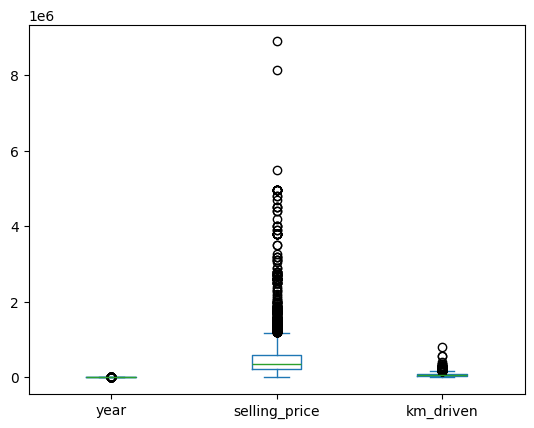

In [15]:
# Boxplot pour détecter les anomalies
import matplotlib.pyplot as plt
import seaborn as sns

df.plot.box()
plt.show()



In [16]:
# Visualisation avec Plotly
import plotly.express as px
fig = px.box(df, x="year", y="km_driven", color="selling_price")
fig.show()


# Étape 3 : Transformation des Données


Nous préparons les données pour les modèles en encodant les colonnes catégoriques et en manipulant les colonnes nécessaires.



In [ ]:
# Copie des données pour transformation
df1 = df.copy()

Encodage des colonnes catégoriques

Chaque valeur textuelle est convertie en valeur numérique pour que les algorithmes de machine learning puissent traiter ces colonnes. Cela est essentiel car la plupart des modèles ne peuvent pas travailler directement avec des données non numériques.


In [ ]:
df1['fuel'].replace({'Diesel': 0, 'Petrol': 1, 'LPG': 2, 'CNG': 3, 'Electric': 4}, inplace=True)
df1.replace({'Automatic': 0, 'Manual': 1}, inplace=True)
df1.replace({'First Owner': 0, 'Second Owner': 1, 'Third Owner': 2, 'Fourth & Above Owner': 3, 'Test Drive Car': 4}, inplace=True)
df1.replace({'Dealer': 0, 'Individual': 1, 'Trustmark Dealer': 2}, inplace=True)

<ipython-input-8-9053623a2ce4>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-8-9053623a2ce4>:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



 Création d'une nouvelle colonne "brand"

In [ ]:
df1['brand'] = df1['name'].str.split().str[0]
df1.drop('name', axis=1, inplace=True)

Encodage des marques

Cette étape permet d'assigner un entier unique à chaque marque de voiture, facilitant leur traitement dans les modèles.

In [ ]:
brands = df1['brand'].unique()
brand_mapping = {brand: i for i, brand in enumerate(brands)}
df1['brand'] = df1['brand'].map(brand_mapping)

print("Données transformées :")
print(df1.head())

Données transformées :
   year  selling_price  km_driven  fuel  seller_type  transmission  owner  \
0  2007          60000      70000     1            1             1      0   
1  2007         135000      50000     1            1             1      0   
2  2012         600000     100000     0            1             1      0   
3  2017         250000      46000     1            1             1      0   
4  2014         450000     141000     0            1             1      1   

   brand  
0      0  
1      0  
2      1  
3      2  
4      3  




Les colonnes catégoriques ont été encodées et une nouvelle colonne "brand" a été ajoutée pour représenter la marque de chaque voiture. Ces transformations permettent aux modèles d'analyser efficacement les relations entre les caractéristiques et le prix de vente.


# Étape 4 : Création et Entraînement de Modèles


Nous testons différents modèles et pipelines pour trouver celui qui donne les meilleures performances.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Séparation des données
X = df1.drop('selling_price', axis=1)
y = df1['selling_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline pour Random Forest

make_column_transformer permet de traiter différentes colonnes de manière distincte. Ici, les colonnes numériques sont imputées avec la moyenne et les colonnes catégoriques sont encodées avec OneHotEncoder.

 Cela permet de simplifier le prétraitement des données, surtout lorsque différentes transformations sont nécessaires selon le type de colonne.

In [ ]:
tree_processor = make_column_transformer(
    (SimpleImputer(strategy="mean"), ['year', 'km_driven']),
    (OneHotEncoder(handle_unknown="ignore"), ['brand'])
)

rfr_pipeline = make_pipeline(tree_processor, RandomForestRegressor(n_estimators=100, random_state=42))
rfr_pipeline.fit(X_train, y_train)

print("Score Random Forest :")
print(rfr_pipeline.score(X_train, y_train) * 100)
print(rfr_pipeline.score(X_test, y_test) * 100)

Score Random Forest :
94.98713128770905
68.38479920517553


# Pipeline pour Lasso Regression

StandardScaler est utilisé pour normaliser les données, ce qui est souvent nécessaire pour des modèles linéaires comme LassoCV.

In [ ]:
linear_preprocessor = make_column_transformer(
    (make_pipeline(StandardScaler(), SimpleImputer(strategy="mean")), ['year', 'km_driven']),
    (OneHotEncoder(handle_unknown="ignore"), ['brand'])
)

lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
lasso_pipeline.fit(X_train, y_train)

print("Score Lasso Regression :")
print(lasso_pipeline.score(X_train, y_train) * 100)
print(lasso_pipeline.score(X_test, y_test) * 100)

Score Lasso Regression :
68.0138530043312
49.89068160473611




Nous avons testé plusieurs modèles, notamment RandomForestRegressor et LassoCV.

Random Forest est un modèle basé sur des arbres de décision, robuste face à des données non linéaires et souvent performant sans nécessiter de normalisation préalable.

En revanche, LassoCV, qui effectue une régularisation L1, est utile pour réduire l'impact des variables moins pertinentes.


# Étape 5 : Enregistrement du Modèle avec MLflow


MLflow est utilisé pour gérer les modèles, versionner et suivre leurs performances de manière centralisée.




In [ ]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("Car Price Prediction")

with mlflow.start_run():
    mlflow.sklearn.log_model(rfr_pipeline, artifact_path="random_forest_pipeline")
    mlflow.log_metric("train_score", rfr_pipeline.score(X_train, y_train))
    mlflow.log_metric("test_score", rfr_pipeline.score(X_test, y_test))

print("Modèle Random Forest enregistré avec succès dans MLflow.")


# Étape 6 : Déploiement avec FastAPI


FastAPI est utilisé pour déployer les modèles sous forme d'API. Cela permet à d'autres applications de faire des prédictions en envoyant des requêtes HTTP.



In [ ]:
from fastapi import FastAPI

app = FastAPI()

@app.get("/status")
def status():
    return {"status": "Le modèle est prêt pour les prédictions."}



La fonction predict prend en entrée les caractéristiques d'un véhicule (année, kilométrage, type de carburant, etc.),
    les transforme au format attendu par le modèle, et retourne une prédiction du prix de vente estimé.

In [ ]:
@app.post("/predict")
def predict(year: int, km_driven: int, fuel: int, transmission: int, owner: int, brand: int):
    input_data = pd.DataFrame([[year, km_driven, fuel, transmission, owner, brand]],
                              columns=['year', 'km_driven', 'fuel', 'transmission', 'owner', 'brand'])
    prediction = rfr_pipeline.predict(input_data)
    return {"predicted_price": prediction[0]}


# Étape 7 : Ajout de SHAP pour l'Explicabilité


SHAP est une bibliothèque qui permet de comprendre les décisions des modèles. Les graphiques comme `summary_plot` montrent quelles caractéristiques influencent le plus les prédictions.



Dans un graphique SHAP, chaque point représente une instance (une observation). L'axe horizontal indique l'impact de la caractéristique sur la prédiction, positif ou négatif. Les couleurs (rouge et bleu) montrent si la valeur de la caractéristique est élevée ou basse. Par exemple, des points rouges à droite indiquent une forte valeur d'une caractéristique qui augmente la prédiction.

Cela permet de comprendre quelles caractéristiques sont les plus importantes dans les décisions du modèle.

In [ ]:
import shap

SHAP permet d'expliquer les prédictions du modèle en attribuant à chaque caractéristique une valeur qui représente son impact positif ou négatif sur la prédiction.


In [ ]:
explainer = shap.Explainer(rfr_pipeline.predict, X_train)
shap_values = explainer(X_test)

Le graphique summary_plot présente les caractéristiques les plus influentes sur l'ensemble des prédictions, ainsi que leurs impacts respectifs (positifs ou négatifs).


In [ ]:
shap.summary_plot(shap_values, X_test)


# Conclusion


Ce projet illustre tout le cycle de vie d'un modèle machine learning : exploration des données, création, entraînement, enregistrement, déploiement, et explicabilité.

Les outils utilisés comme MLflow et SHAP rendent ce processus robuste et transparent.

**Prochaines étapes :** essayer d'autres modèles, explorer des approches comme Gradient Boosting, et améliorer l'expérience utilisateur.

